In [4]:
import sys
import tskit
import msprime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import msprime
from collections import Counter
from multiprocessing import Pool, cpu_count
from copy import deepcopy
import pandas as pd

In [5]:
def get_population_time(time_rate:float=0.06, tmax:int = 130_000,
                        num_time_windows:int = 21
                       ) -> np.array :
    """Creates population time points; used as time points to change
    population size changes for simulation
    
    :return numpy.ndarray: time points of length num_time_windows
    """
    
    population_time = np.repeat([(np.exp(np.log(1 + time_rate * tmax) * i /
                              (num_time_windows - 1)) - 1) / time_rate for i in
                              range(num_time_windows)], 1, axis=0)
    population_time[0] = 1
    return population_time

def sample_population_size(n_min:int=10, n_max:int=100_000, num_time_windows=21) -> list[float]:
    
    """Creates random demography. Function taken from: 
    https://gitlab.inria.fr/ml_genetics/public/dlpopsize_paper
    
    :param int n_min: Lower-bound of demography.
    :param int n_max: Upper-bound of demography.
    :param int num_time_windows: Number of population sizes in demography.
    :return list: 
    """
    
    n_min_log10 = np.log10(n_min)
    n_max_log10 = np.log10(n_max)
    population_size = [10 ** np.random.uniform(low=n_min_log10, high=n_max_log10)] 
    for j in range(num_time_windows - 1):
        population_size.append(10 ** n_min_log10 - 1)
        while population_size[-1] > 10 ** n_max_log10 or population_size[-1]  < 10 ** n_min_log10:
            population_size[-1] = population_size[-2] * 10 ** np.random.uniform(-1, 1)
            
    return population_size



In [6]:
np.random.seed(123456)

from scipy.interpolate import interp1d
upper_out_of_bound = lower_out_of_bound = True
while upper_out_of_bound or lower_out_of_bound:
    steps = 18
    x = np.log(get_population_time(time_rate=0.1, num_time_windows=steps, tmax=10_000_000).tolist())
    y = np.log(sample_population_size(10_000, 10_000_000, steps))
    xnew = np.linspace(x[0], x[-1], num=10000, endpoint=True)
    f_cubic = interp1d(x, y, kind='cubic')
    ynew = f_cubic(xnew)
    upper_out_of_bound = np.sum(np.exp(ynew) > 10_000_000) > 0
    lower_out_of_bound = np.sum(np.exp(ynew) < 10_000) > 0
    

x_sample = xnew[np.linspace(10, 9999, 60).astype(int)]
y_sample = ynew[np.linspace(10, 9999, 60).astype(int)]

population_time = np.exp(x_sample)

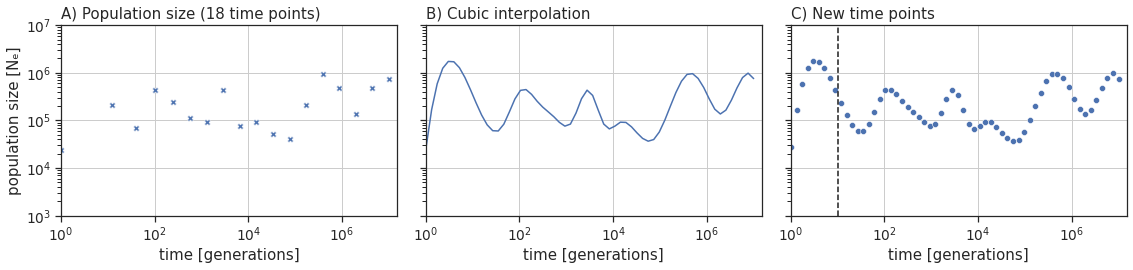

In [22]:
sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axes = plt.subplots(1, 3, figsize=(16,4), sharex=True, sharey=True)
x_sample = xnew[np.linspace(10, 9999, 60).astype(int)]
y_sample = ynew[np.linspace(10, 9999, 60).astype(int)]

sns.scatterplot(x=np.exp(x), y=np.exp(y), marker="X", ax=axes[0]).set_title("A) Population size (18 time points)", loc="left")
sns.lineplot(x=np.exp(x_sample), y=np.exp(y_sample), ax=axes[1]).set_title("B) Cubic interpolation", loc="left")
sns.scatterplot(x=np.exp(x_sample), y=np.exp(y_sample), ax=axes[2]).set_title("C) New time points", loc="left")

plt.axvline(x=10, color='k', linestyle='--')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1000, 10_000_000)
plt.xlim(1, 15_000_000)
axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)
axes[0].set(xlabel="time [generations]", ylabel="population size [Nₑ]")
axes[1].set(xlabel="time [generations]", ylabel="population size [Nₑ]")
axes[2].set(xlabel="time [generations]", ylabel="population size [Nₑ]")


population_time = np.exp(x_sample)

plt.tight_layout()


fig.savefig("../figures/Figure_S3_1.pdf", dpi=600)

#### masking code:

In [13]:
def get_sorted_log_trees_node_times(ts: tskit.trees.TreeSequence, trees: list[tskit.trees.Tree]) -> list[list[float]]:
    
    """ Creates list of list of all node_times for each tree. Times are sorted, natural log-scaled and padded on the right 
    side with last node time value, so all node times are of equal length. Padding important to calculate masks for infered
    trees or non-wright-fisher models. All leave node times are removed, because these are just zero.
    
    Arg types:
        * **ts** *(tskit tree sequence)* - Input simulated or infered tree sequence.
        * **trees** *(list of tskit trees)* - List of trees, e.g. ts.aslist(), discretize_trees(ts.aslist(), num_trees)
    Return types:
        * **output** *(list of list)* - list of list of node times for each tree, sorted, natural log-scaled and right-padded.
    """
    
    output = []
    
    node_times = np.array([node.time for node in ts.nodes()])
    
    num_leave_nodes = ts.get_sample_size()
    num_non_leave_nodes = 2 * num_leave_nodes - 1 - num_leave_nodes
    
    for tree in trees:
        current_tree_node_times = filter_node_times(node_times, tree)
        
        current_tree_node_times = sorted(current_tree_node_times)
        current_tree_node_times = [time for time in current_tree_node_times if time != 0]
        log_current_tree_node_times = np.log(current_tree_node_times).tolist()
                
        while len(log_current_tree_node_times) != num_non_leave_nodes:
            log_current_tree_node_times.append(log_current_tree_node_times[-1])
            
        output.append(log_current_tree_node_times)
        
    return output

def get_binned_coalescent_times(ts, binned_population_time, num_time_windows:int,  num_trees: int = 500) -> list:
    """ Number of coalescent events for each time window for discretized trees.
    """
        
    #new_pop_time = get_new_poptime()
    #print(new_pop_time[-1], new_pop_time[0])


    binned_population_time = np.array(binned_population_time)
    sorted_log_trees_node_times = get_sorted_log_trees_node_times(ts, ts.aslist()[:num_trees])
    tree_times = np.exp(np.array(sorted_log_trees_node_times))
        
    tree_bins = [] 
    outside_window = 0
    
    for current_tree_times in tree_times:
                
        for i, time in enumerate(current_tree_times):
            if time >= population_time[-1]:
                outside_window += 1
                time_window = binned_population_time.shape[0]
                tree_bins.append(time_window)
            elif time < population_time[0]:
                outside_window += 1
                tree_bins.append(0)

            else:
                time_window = np.argwhere(np.sum(binned_population_time < time, axis=1) == 1).item()
                tree_bins.append(time_window)
            
    coalescent_times = sorted(np.array(tree_bins).flatten().tolist())
    coalescent_time_lookup = dict(Counter(coalescent_times))
    expand_coalescent_lookup(coalescent_time_lookup, num_time_windows=num_time_windows)
    coalescent_times = [item[1] for item in sorted(coalescent_time_lookup.items())]
    
    return coalescent_times


def uniformize_mask_with_hacky_heuristic(mask, num_time_windows=50, num_replicates=100):

    
    # first heuristic: choosing mask based sliding window
    column_wise_mask = mask.sum(0)
    copied_mask = deepcopy(mask)
    copied_mask[:] = False

    
    pos0 = column_wise_mask[0] == num_replicates
    pos1 = column_wise_mask[1] == num_replicates
    pos2 = column_wise_mask[2] == num_replicates
    pos3 = column_wise_mask[3] == num_replicates
    pos4 = column_wise_mask[4] == num_replicates
    pos5 = column_wise_mask[5] == num_replicates
    
    if pos2 and pos3 and pos4:
        copied_mask[:,1] = True
    if pos3 and pos4 and pos5:
        copied_mask[:,2] = True
    
    
    for i in range(3, num_time_windows-3):

        left_one = column_wise_mask[i-1] == num_replicates
        left_two = column_wise_mask[i-2] == num_replicates
        left_three = column_wise_mask[i-3] == num_replicates
        right_one = column_wise_mask[i+1] == num_replicates
        right_two = column_wise_mask[i+2] == num_replicates
        right_three = column_wise_mask[i+3] == num_replicates

        if np.sum([left_one, left_two, left_three, right_one, right_two, right_three]) >= 3:
            copied_mask[:,i] = True

             
    # second heuristic: selecting the largest continous interval
    row = copied_mask[0].tolist()
    all_length = []
    all_idxs = []
    tupled_all_idxs = []

    current_length = 0
    for i, r in enumerate(row):
        if r == True:    
            if current_length == 0:
                first_idx = i
                all_idxs.append(first_idx)
            current_length += 1    
        else:
            if current_length != 0:            
                all_length.append(current_length)
                last_idx = i
                all_idxs.append(last_idx)
            current_length = 0

    if current_length != 0:
        all_length.append(current_length)
        last_idx = i
        all_idxs.append(last_idx)

    for i in range(0, len(all_idxs), 2):
        tupled_all_idxs.append([all_idxs[i], all_idxs[i+1]])

    mask_idxs = tupled_all_idxs[np.argmax(all_length)]
    copied_mask = deepcopy(mask)
    copied_mask[:] = False
    copied_mask[:,mask_idxs[0]:mask_idxs[1]] = True
    
    return copied_mask

def compute_mask_from_tree_sequences(tree_sequences,
                                     population_time,
                                     num_cpus=1,
                                     num_replicates=100,
                                     min_coal_tree=30):

    num_time_windows = len(population_time)    
    binned_population_time = [[population_time[i], population_time[i+1]] for i in range(len(population_time)-1)]
    
    args = []
    for ts in tree_sequences:
        args.append((ts, binned_population_time, num_time_windows))

    with Pool(num_cpus) as p: 
        coalescent_times_replicates = p.starmap(get_binned_coalescent_times, args)
    
    coalescent_times_replicates = np.array(coalescent_times_replicates)

    mask = coalescent_times_replicates >= min_coal_tree
    mask[:, mask.sum(0) >= min_coal_tree] = True
    mask[:, mask.sum(0) < min_coal_tree] = False
    mask = uniformize_mask_with_hacky_heuristic(mask, num_time_windows, num_replicates=num_replicates)
    
    return coalescent_times_replicates, mask

    
def expand_coalescent_lookup(coalescent_time_lookup: dict, num_time_windows):
    for i in range(num_time_windows):
        if i not in coalescent_time_lookup.keys():
            coalescent_time_lookup[i] = 0

def filter_node_times(node_times:list[float] , tree:tskit.trees.Tree)->list[float]:
    """ Filters list of all tree sequence node times to only contain node times of given tree.
    Arg types:
        * **node_times** *(list)* - list containing node times, index 0 contains node time of node 0, index 1 of node 1 and so on.
        * **tree** (tskit tree object) - tskit tree of which node times should be extracted
    Return types:
        * **tree_node_times** - list of node times of given tree
    """
    current_tree_nodes = [node for node in tree.nodes()]
    current_tree_node_times = node_times[current_tree_nodes].tolist()
    return current_tree_node_times


In [14]:
def reformat(col_events , mask):
    ce = col_events / col_events.max()
    ce = pd.DataFrame(ce, columns=np.round(population_time)) 
    mask = pd.DataFrame(mask, columns=np.round(population_time))
    return ce, mask

In [15]:
def beta_constant(alpha, Ne = 10**6, r=5e-8,  L=10**4, num_replicates=1000):
    
    sample_size=10
    mu=1e-8
    
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))

    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = msprime.sim_ancestry(samples=10,
                                          recombination_rate=r, sequence_length=L, demography=demography,
                                          ploidy=1,model=msprime.BetaCoalescent(alpha=alpha),
                                          num_replicates=num_replicates)
    demography = db.population_size_trajectory(population_time).flatten()
    
    return list(tree_sequences), demography 


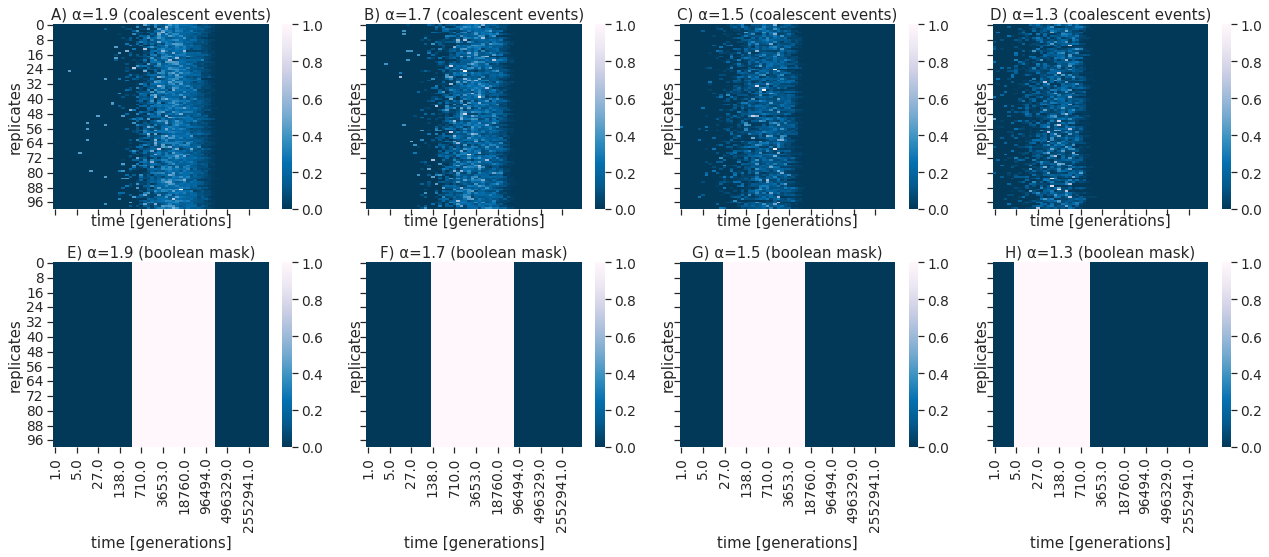

In [20]:


fig, axs = plt.subplots(2, 4, figsize=(18,8), sharex=True, sharey=True)

tree_sequences, demography = beta_constant(1.9, num_replicates=100, r=1e-8, L=1e6)
col_events , mask = compute_mask_from_tree_sequences(tree_sequences, population_time, num_cpus=7, min_coal_tree=30)
ce, mask = reformat(col_events , mask)
sns.heatmap(ce, ax=axs[0][0], cmap="PuBu_r" ).set_title("A) α=1.9 (coalescent events)")
sns.heatmap(mask, ax=axs[1][0], cmap="PuBu_r" ).set_title("E) α=1.9 (boolean mask)")


tree_sequences, demography = beta_constant(1.7, num_replicates=100, r=1e-8, L=5e6)
col_events , mask = compute_mask_from_tree_sequences(tree_sequences, population_time, num_cpus=7, min_coal_tree=30)
ce, mask = reformat(col_events , mask)
sns.heatmap(ce, ax=axs[0][1], cmap="PuBu_r" ).set_title("B) α=1.7 (coalescent events)")
sns.heatmap(mask, ax=axs[1][1], cmap="PuBu_r" ).set_title("F) α=1.7 (boolean mask)")

tree_sequences, demography = beta_constant(1.5, num_replicates=100, r=1e-8, L=50e6)
col_events , mask = compute_mask_from_tree_sequences(tree_sequences, population_time, num_cpus=7, min_coal_tree=30)
ce, mask = reformat(col_events , mask)
sns.heatmap(ce, ax=axs[0][2], cmap="PuBu_r" ).set_title("C) α=1.5 (coalescent events)")
sns.heatmap(mask, ax=axs[1][2], cmap="PuBu_r" ).set_title("G) α=1.5 (boolean mask)")

tree_sequences, demography = beta_constant(1.3, num_replicates=100, r=1e-8, L=100e6)
col_events , mask = compute_mask_from_tree_sequences(tree_sequences, population_time, num_cpus=7, min_coal_tree=30)
ce, mask = reformat(col_events , mask)
sns.heatmap(ce, ax=axs[0][3], cmap="PuBu_r" ).set_title("D) α=1.3 (coalescent events)")
sns.heatmap(mask, ax=axs[1][3], cmap="PuBu_r" ).set_title("H) α=1.3 (boolean mask)")

axs[0][0].set(ylabel="replicates", xlabel="time [generations]")
axs[0][1].set(ylabel="replicates", xlabel="time [generations]")
axs[0][2].set(ylabel="replicates", xlabel="time [generations]")
axs[0][3].set(ylabel="replicates", xlabel="time [generations]")

axs[1][0].set(ylabel="replicates", xlabel="time [generations]")
axs[1][1].set(ylabel="replicates", xlabel="time [generations]")
axs[1][2].set(ylabel="replicates", xlabel="time [generations]")
axs[1][3].set(ylabel="replicates", xlabel="time [generations]")


plt.tight_layout()
fig.savefig("../figures/appendix_2_mask_coal.pdf", dpi=600)